In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, classification_report, roc_auc_score, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay, precision_recall_curve, roc_curve
from sklearn import set_config
set_config("figure")
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [72]:
data = pd.read_csv('/Users/sheetalchaudhari/Documents/Cancer_Classification/UBC_Ovarian_Cancer_train.csv')

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      538 non-null    int64 
 1   label         538 non-null    object
 2   image_width   538 non-null    int64 
 3   image_height  538 non-null    int64 
 4   is_tma        538 non-null    bool  
dtypes: bool(1), int64(3), object(1)
memory usage: 17.5+ KB


In [3]:
data.head()

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False


In [4]:
data.label.unique()

array(['HGSC', 'LGSC', 'EC', 'CC', 'MC'], dtype=object)

In [5]:
data.isnull().values.any()

False

# Data Preparation

In [6]:
# After reviewing the datasets, I concluded that image_width and image_height are the key features
data = data[["image_width","image_height","label"]]

In [7]:
data.head()

,image_width,image_height,label
0,23785,20008,HGSC
1,48871,48195,LGSC
2,3388,3388,HGSC
3,42309,15545,LGSC
4,37204,30020,EC


# Baseline Model

In [8]:
# Create baseline models with Logistic Regression, KNN, Decision Tree, Support Vector Machines, 
# AdaBoostClassifier and RandomForestClassifier

In [9]:
X = data[["image_width", "image_height"]]
y = data["label"]

In [10]:
# Split the dataset into training and test datasets
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
pipelines = {
    'lr_baseline' : Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression())]),
    'knn_baseline': Pipeline([('scaler', StandardScaler()), ('classifier', KNeighborsClassifier())]), 
    'dt_baseline' : Pipeline([('scaler', StandardScaler()), ('classifier', DecisionTreeClassifier())]),
    'svm_baseline' : Pipeline([('scaler', StandardScaler()), ('classifier', SVC())]),
    'ada_baseline' : Pipeline([('scaler', StandardScaler()), ('classifier', AdaBoostClassifier())]),
    'rf_baseline' : Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier())]) 
}

In [12]:
scores_baseline = {}
for model_name, pipeline in pipelines.items(): 
    pipeline.fit(X_base_train, y_base_train.values.ravel())
    score = cross_val_score(pipeline, X_base_train, y_base_train.values.ravel(), cv=5, scoring='accuracy').mean()
    scores_baseline[model_name] = score
    print(f"{model_name} with accuracy score {score: .3f}")

lr_baseline with accuracy score  0.416
knn_baseline with accuracy score  0.333
dt_baseline with accuracy score  0.312
svm_baseline with accuracy score  0.416
ada_baseline with accuracy score  0.309
rf_baseline with accuracy score  0.314


# Logistic Regression

In [13]:
X_lr = data[["image_width", "image_height"]]
y_lr = data["label"]

In [14]:
# Split the dataset into training and test datasets
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X_lr, y_lr, test_size = 0.2, random_state = 42)

In [15]:
lr_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(multi_class='auto'))])

In [16]:
#Hyperparameter tuning
hyperparameters = {'classifier__solver': ['liblinear','lbfgs'],
                   'classifier__penalty' : ['l1', 'l2'],
                   'classifier__C' :[0.001,0.01, 0.1, 1, 100]
                  }

grid_search = GridSearchCV(lr_pipe, hyperparameters, cv=5, scoring='accuracy')
grid_search.fit(X_lr_train, y_lr_train.values.ravel())
print(f"Best Parameters : {grid_search.best_params_}")
print(f"Best Accuracy Score : {grid_search.best_score_}")

Best Parameters : {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Accuracy Score : 0.4186046511627907


/Users/sheetalchaudhari/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sheetalchaudhari/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sheetalchaudhari/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sheetalchaudhari/anaconda3/lib/python3.11/s

In [17]:
optimal_lr_model = grid_search.best_estimator_

In [18]:
y_lr_pred = optimal_lr_model.predict(X_lr_test)

In [19]:
print(classification_report(y_lr_test, y_lr_pred))

              precision    recall  f1-score   support

          CC       0.00      0.00      0.00        15
          EC       0.00      0.00      0.00        30
        HGSC       0.39      1.00      0.56        42
        LGSC       0.00      0.00      0.00        12
          MC       0.00      0.00      0.00         9

    accuracy                           0.39       108
   macro avg       0.08      0.20      0.11       108
weighted avg       0.15      0.39      0.22       108



/Users/sheetalchaudhari/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sheetalchaudhari/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sheetalchaudhari/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

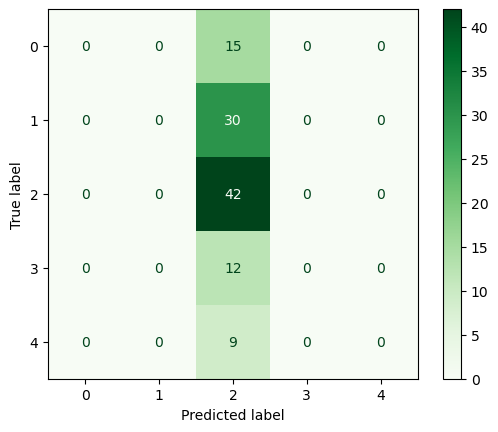

In [20]:
cm_lr = confusion_matrix(y_true=y_lr_test, y_pred=y_lr_pred)
ConfusionMatrixDisplay(cm_lr).plot(cmap=plt.cm.Greens)

In [21]:
optimal_lr_model.predict_proba(X_lr_test)[:,1]

array([0.20069668, 0.20082902, 0.20052081, 0.20091982, 0.2009428 ,
       0.20068038, 0.20073697, 0.20113267, 0.20090909, 0.2007956 ,
       0.20031474, 0.20050695, 0.2005354 , 0.20047058, 0.2003672 ,
       0.2010008 , 0.20120131, 0.20085122, 0.20061888, 0.20109414,
       0.20076716, 0.20044397, 0.20084816, 0.20058381, 0.20041249,
       0.20076716, 0.20049745, 0.20076716, 0.20080298, 0.2009027 ,
       0.20049232, 0.20023824, 0.20108466, 0.20070872, 0.20055452,
       0.2011102 , 0.20065986, 0.20051056, 0.2012157 , 0.20085403,
       0.20076313, 0.20076313, 0.20014437, 0.20085273, 0.20077568,
       0.20077321, 0.20080821, 0.20076313, 0.20056051, 0.20112215,
       0.2008786 , 0.20121755, 0.20086401, 0.20084395, 0.20093295,
       0.20061279, 0.20048033, 0.20059978, 0.20066707, 0.20092459,
       0.20047106, 0.20111952, 0.20076313, 0.20107318, 0.20066567,
       0.20095958, 0.20111205, 0.20101498, 0.20059889, 0.20077984,
       0.20088237, 0.20045819, 0.20086293, 0.20098098, 0.20114

In [22]:
roc_auc_lr = roc_auc_score(y_lr_test.values.ravel(),optimal_lr_model.predict_proba(X_lr_test),multi_class='ovo')
print(f"ROC AUC Score for Logistic Regression Model: {roc_auc_lr} ")

ROC AUC Score for Logistic Regression Model: 0.5713902116402115 


# K Nearest Neighbor

In [23]:
X_knn = data[["image_width", "image_height"]]
y_knn = data["label"]

In [24]:
# Split the dataset into training and test datasets
X_knn_train, X_knn_test, y_knn_train, y_knn_test = train_test_split(X_knn, y_knn, test_size = 0.2, random_state = 42)

In [25]:
scaler = StandardScaler()
scaler.fit(X_knn_train)

StandardScaler()

In [26]:
scaler.mean_

array([49487.53255814, 30229.02093023])

In [27]:
X_knn_train = pd.DataFrame(scaler.transform(X_knn_train))
X_knn_train.head(10)

,0,1
0,0.726470,-0.211174
1,0.818840,0.251812
2,-1.276691,-1.073671
3,1.081902,-0.264038
4,-2.363029,-2.542872
5,-0.346643,0.229454
6,-0.407385,-0.314533
7,-0.870461,0.813895
8,0.562748,1.389051
9,0.284718,1.406956


In [28]:
#Use Cross validation to determine the best value of k
neighbors = range(1,101)
cv_scores=[]

for k in neighbors: 
    print(f"Calculating for k={k}")
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_knn_train, y_knn_train.values.ravel(),cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

Calculating for k=1
Calculating for k=2
Calculating for k=3
Calculating for k=4
Calculating for k=5
Calculating for k=6
Calculating for k=7
Calculating for k=8
Calculating for k=9
Calculating for k=10
Calculating for k=11
Calculating for k=12
Calculating for k=13
Calculating for k=14
Calculating for k=15
Calculating for k=16
Calculating for k=17
Calculating for k=18
Calculating for k=19
Calculating for k=20
Calculating for k=21
Calculating for k=22
Calculating for k=23
Calculating for k=24
Calculating for k=25
Calculating for k=26
Calculating for k=27
Calculating for k=28
Calculating for k=29
Calculating for k=30
Calculating for k=31
Calculating for k=32
Calculating for k=33
Calculating for k=34
Calculating for k=35
Calculating for k=36
Calculating for k=37
Calculating for k=38
Calculating for k=39
Calculating for k=40
Calculating for k=41
Calculating for k=42
Calculating for k=43
Calculating for k=44
Calculating for k=45
Calculating for k=46
Calculating for k=47
Calculating for k=48
C

In [29]:
cv_scores

[0.2697674418604651,
 0.3046511627906977,
 0.3302325581395349,
 0.34418604651162793,
 0.3302325581395349,
 0.3325581395348837,
 0.3186046511627907,
 0.31860465116279074,
 0.33720930232558144,
 0.3511627906976744,
 0.35813953488372097,
 0.36279069767441857,
 0.35348837209302325,
 0.3558139534883721,
 0.3534883720930233,
 0.3651162790697674,
 0.35813953488372097,
 0.36744186046511634,
 0.3813953488372093,
 0.386046511627907,
 0.38139534883720927,
 0.39767441860465114,
 0.39302325581395353,
 0.38139534883720927,
 0.4,
 0.3837209302325581,
 0.4,
 0.4,
 0.3906976744186047,
 0.4,
 0.40930232558139534,
 0.39767441860465114,
 0.3953488372093023,
 0.4046511627906977,
 0.40930232558139534,
 0.41395348837209295,
 0.41395348837209295,
 0.4046511627906977,
 0.4069767441860465,
 0.40930232558139534,
 0.4116279069767441,
 0.4116279069767441,
 0.40930232558139534,
 0.41162790697674423,
 0.4162790697674419,
 0.41162790697674423,
 0.4162790697674419,
 0.41395348837209306,
 0.41860465116279066,
 0.418604

# Plot k v/s accuracy

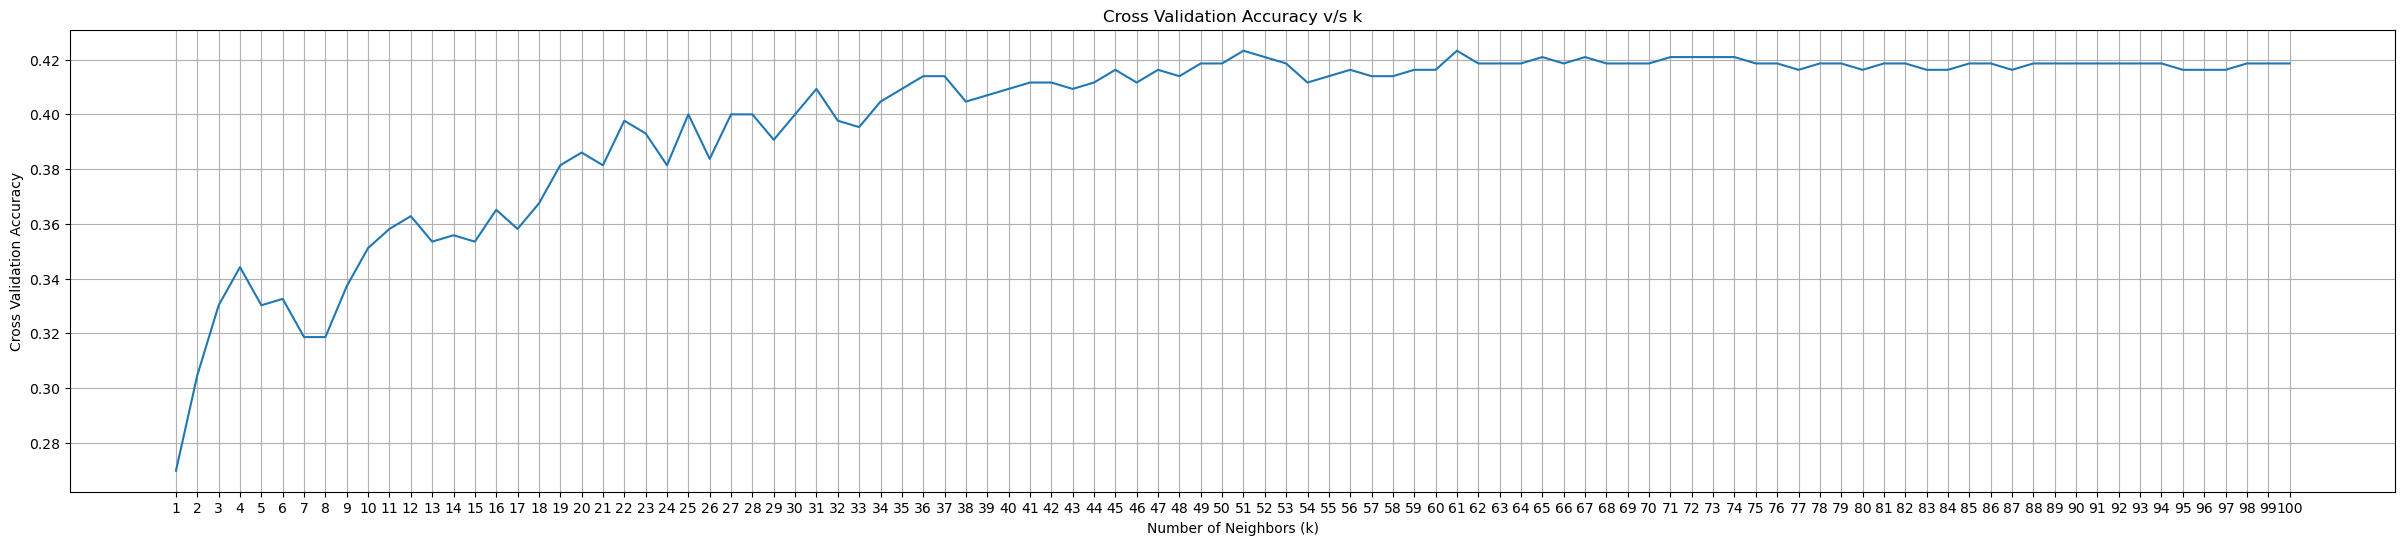

In [30]:
# Plot k v/s accuracy
plt.figure(figsize = (30,6))
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross Validation Accuracy')
plt.title('Cross Validation Accuracy v/s k')
plt.xticks(range(1,101))
plt.grid()
plt.show()

In [31]:
# Best value of k = 51 based on the above plot
knn_optimal = KNeighborsClassifier(n_neighbors = 51)
knn_optimal.fit(X_knn_train, y_knn_train.values.ravel())
X_knn_test_scaled = pd.DataFrame(scaler.transform(X_knn_test))
y_knn_pred = knn_optimal.predict(X_knn_test_scaled)

In [32]:
knn_optimal.predict_proba(X_knn_test_scaled)

array([[0.2745098 , 0.19607843, 0.31372549, 0.07843137, 0.1372549 ],
       [0.15686275, 0.23529412, 0.49019608, 0.05882353, 0.05882353],
       [0.23529412, 0.19607843, 0.43137255, 0.09803922, 0.03921569],
       [0.09803922, 0.23529412, 0.52941176, 0.1372549 , 0.        ],
       [0.11764706, 0.23529412, 0.49019608, 0.1372549 , 0.01960784],
       [0.19607843, 0.25490196, 0.41176471, 0.09803922, 0.03921569],
       [0.05882353, 0.23529412, 0.52941176, 0.15686275, 0.01960784],
       [0.21568627, 0.25490196, 0.2745098 , 0.03921569, 0.21568627],
       [0.19607843, 0.21568627, 0.35294118, 0.05882353, 0.17647059],
       [0.11764706, 0.2745098 , 0.33333333, 0.19607843, 0.07843137],
       [0.19607843, 0.19607843, 0.52941176, 0.05882353, 0.01960784],
       [0.23529412, 0.15686275, 0.45098039, 0.11764706, 0.03921569],
       [0.01960784, 0.21568627, 0.62745098, 0.11764706, 0.01960784],
       [0.25490196, 0.23529412, 0.37254902, 0.01960784, 0.11764706],
       [0.17647059, 0.23529412, 0.

In [33]:
print(classification_report(y_knn_test, y_knn_pred))

              precision    recall  f1-score   support

          CC       0.00      0.00      0.00        15
          EC       0.00      0.00      0.00        30
        HGSC       0.39      0.98      0.55        42
        LGSC       0.00      0.00      0.00        12
          MC       0.00      0.00      0.00         9

    accuracy                           0.38       108
   macro avg       0.08      0.20      0.11       108
weighted avg       0.15      0.38      0.22       108



/Users/sheetalchaudhari/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sheetalchaudhari/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sheetalchaudhari/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

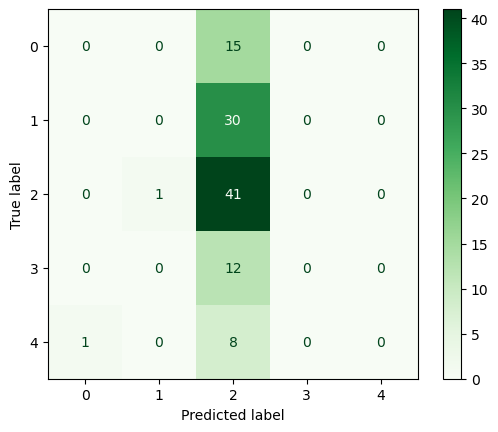

In [34]:
cm_knn = confusion_matrix(y_true=y_knn_test, y_pred=y_knn_pred)
ConfusionMatrixDisplay(cm_knn).plot(cmap=plt.cm.Greens)

In [35]:
roc_auc_knn = roc_auc_score(y_knn_test.values.ravel(),knn_optimal.predict_proba(X_knn_test),multi_class='ovo')
print(f"ROC AUC Score for KNN Model: {roc_auc_knn} ")

ROC AUC Score for KNN Model: 0.48513955026455025 


/Users/sheetalchaudhari/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


# Decision Tree

In [36]:
X_dt = data[["image_width", "image_height"]]
y_dt = data["label"]

In [37]:
# Split the dataset into training and test datasets
X_dt_train, X_dt_test, y_dt_train, y_dt_test = train_test_split(X_dt, y_dt, test_size = 0.2, random_state = 42)

In [38]:
dt_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', DecisionTreeClassifier())])
#Hyperparameter tuning
hyperparameters = {'classifier__criterion': ['entropy', 'gini'], 
                   'classifier__max_depth' : [10, 20, 50]
                 }

grid_search = GridSearchCV(dt_pipe, hyperparameters, cv=5, scoring='accuracy')
grid_search.fit(X_dt_train, y_dt_train.values.ravel())
print(f"Best Parameters : {grid_search.best_params_}")
print(f"Best AccuracyScore : {grid_search.best_score_}")

Best Parameters : {'classifier__criterion': 'gini', 'classifier__max_depth': 10}
Best AccuracyScore : 0.3651162790697674


In [39]:
optimal_dt_model = grid_search.best_estimator_
y_dt_pred = optimal_dt_model.predict(X_dt_test)

In [40]:
y_dt_pred

array(['HGSC', 'CC', 'HGSC', 'HGSC', 'HGSC', 'MC', 'HGSC', 'EC', 'EC',
       'HGSC', 'HGSC', 'CC', 'HGSC', 'HGSC', 'CC', 'HGSC', 'CC', 'EC',
       'HGSC', 'HGSC', 'CC', 'HGSC', 'HGSC', 'HGSC', 'HGSC', 'CC', 'CC',
       'CC', 'EC', 'HGSC', 'HGSC', 'HGSC', 'EC', 'HGSC', 'HGSC', 'LGSC',
       'HGSC', 'HGSC', 'EC', 'CC', 'LGSC', 'LGSC', 'CC', 'EC', 'HGSC',
       'HGSC', 'CC', 'LGSC', 'HGSC', 'CC', 'HGSC', 'HGSC', 'CC', 'CC',
       'HGSC', 'HGSC', 'HGSC', 'EC', 'CC', 'CC', 'HGSC', 'MC', 'LGSC',
       'EC', 'EC', 'HGSC', 'HGSC', 'HGSC', 'HGSC', 'HGSC', 'MC', 'EC',
       'HGSC', 'HGSC', 'EC', 'EC', 'HGSC', 'HGSC', 'HGSC', 'HGSC', 'EC',
       'LGSC', 'HGSC', 'HGSC', 'HGSC', 'HGSC', 'EC', 'HGSC', 'HGSC', 'EC',
       'HGSC', 'CC', 'CC', 'EC', 'HGSC', 'HGSC', 'CC', 'CC', 'HGSC',
       'HGSC', 'HGSC', 'EC', 'CC', 'EC', 'HGSC', 'HGSC', 'LGSC', 'HGSC'],
      dtype=object)

In [41]:
print(classification_report(y_dt_test, y_dt_pred))

              precision    recall  f1-score   support

          CC       0.10      0.13      0.11        15
          EC       0.42      0.27      0.33        30
        HGSC       0.40      0.55      0.46        42
        LGSC       0.00      0.00      0.00        12
          MC       0.00      0.00      0.00         9

    accuracy                           0.31       108
   macro avg       0.18      0.19      0.18       108
weighted avg       0.28      0.31      0.29       108



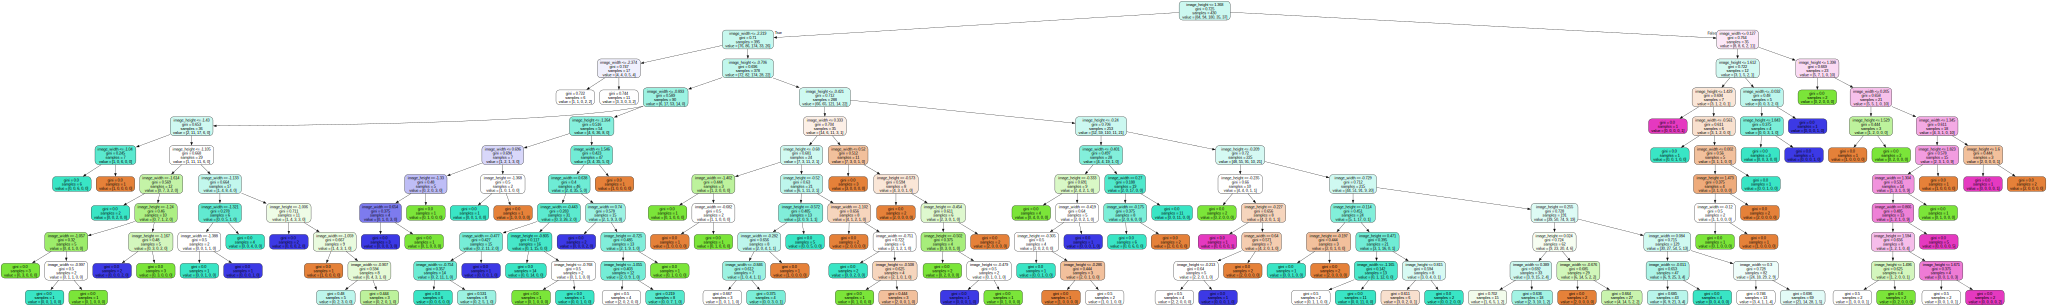

In [42]:
viz = export_graphviz(optimal_dt_model['classifier'], feature_names = X_dt_train.columns, 
                      rounded = True, filled= True)
graph = graphviz.Source(viz)
graph

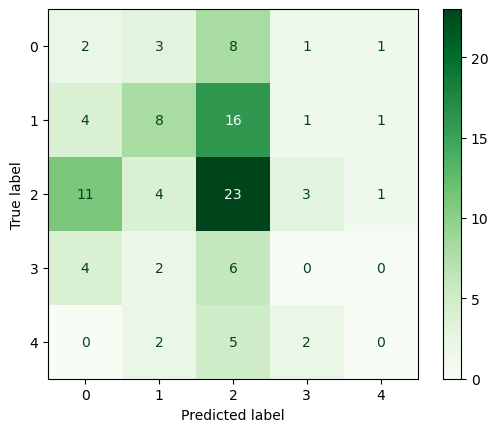

In [43]:
cm_dt = confusion_matrix(y_true=y_dt_test, y_pred=y_dt_pred)
ConfusionMatrixDisplay(cm_dt).plot(cmap=plt.cm.Greens)

In [69]:
roc_auc_dt = roc_auc_score(y_dt_test.values.ravel(),optimal_dt_model.predict_proba(X_dt_test),multi_class='ovo')
print(f"ROC AUC Score for Decision Tree Model: {roc_auc_dt} ")

ROC AUC Score for Decision Tree Model: 0.48393716931216935 


# Support Vector Machines

In [45]:
X_svm = data[["image_width", "image_height"]]
y_svm = data['label']
# Split the dataset into training and test datasets
X_svm_train, X_svm_test, y_svm_train, y_svm_test = train_test_split(X_svm, y_svm, test_size = 0.2, random_state = 42)

In [46]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
cv_scores = []
for k in kernels: 
    print(f"Evaluating {k}")
    svc = SVC(kernel=k)
    scores = cross_val_score(svc, X_svm_train, y_svm_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

optimal_kernel = kernels[cv_scores.index(max(cv_scores))]
print(f"Optimal kernal is {optimal_kernel} with cross-validation score of {max(cv_scores)}")

Evaluating linear
Evaluating poly
Evaluating rbf
Evaluating sigmoid
Optimal kernal is poly with cross-validation score of 0.4186046511627907


In [47]:
# The execution of the below code (160 fits) took very long time and did not complete the execution. 
# So the code is commented.
#params = {
#    'C': [0.1, 1, 10, 100],
#    'gamma' : [1, 0.1, 0.01, 0.001],
#    'kernel': [optimal_kernel],
#    'decision_function_shape' : ['ovo', 'ovr']
#}

#grid = GridSearchCV(SVC(), params, refit = True, verbose = 2, cv=5)
#grid.fit(X_svm_train, y_svm_train)
#print(f"Best parameters found: {grid.best_params_}")

In [48]:
svc_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', SVC(kernel='poly', probability=True))])
svc_pipe.fit(X_svm_train, y_svm_train.values.ravel())
y_svm_pred = svc_pipe.predict(X_svm_test)

In [49]:
print(classification_report(y_svm_test, y_svm_pred))

              precision    recall  f1-score   support

          CC       0.00      0.00      0.00        15
          EC       0.00      0.00      0.00        30
        HGSC       0.37      0.88      0.52        42
        LGSC       0.00      0.00      0.00        12
          MC       0.00      0.00      0.00         9

    accuracy                           0.34       108
   macro avg       0.07      0.18      0.10       108
weighted avg       0.15      0.34      0.20       108



/Users/sheetalchaudhari/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sheetalchaudhari/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sheetalchaudhari/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

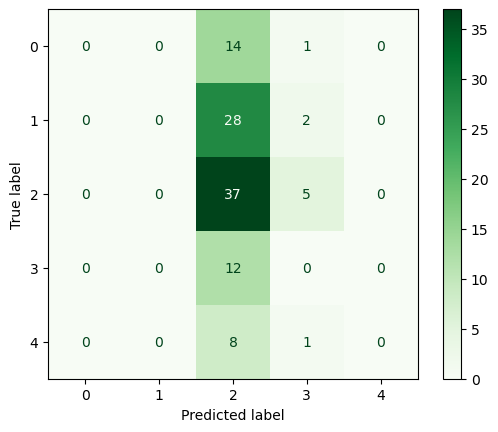

In [50]:
cm_svc = confusion_matrix(y_true=y_svm_test, y_pred=y_svm_pred)
ConfusionMatrixDisplay(cm_svc).plot(cmap=plt.cm.Greens)

In [52]:
roc_auc_svm = roc_auc_score(y_svm_test.values.ravel(),svc_pipe.predict_proba(X_svm_test),multi_class='ovo')
print(f"ROC AUC Score for Support Vector Machine Model: {roc_auc_svm} ")

ROC AUC Score for Support Vector Machine Model: 0.4288174603174603 


# AdaBoost

In [54]:
X_ada = data[["image_width", "image_height"]]
y_ada = data['label']
# Split the dataset into training and test datasets
X_ada_train, X_ada_test, y_ada_train, y_ada_test = train_test_split(X_ada, y_ada, test_size = 0.2, random_state = 42)

In [55]:
ada_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', AdaBoostClassifier())])
#Hyperparameter tuning
hyperparameters = {'classifier__n_estimators': [10, 25, 50], 
                   'classifier__learning_rate' : [0.5, 1, 5],
                   'classifier__algorithm' : ['SAMME', 'SAMME.R']
                 }

grid_search = GridSearchCV(ada_pipe, hyperparameters, cv=5, scoring='accuracy')
grid_search.fit(X_ada_train, y_ada_train.values.ravel())
print(f"Best Parameters : {grid_search.best_params_}")
print(f"Best AccuracyScore : {grid_search.best_score_}")

Best Parameters : {'classifier__algorithm': 'SAMME', 'classifier__learning_rate': 0.5, 'classifier__n_estimators': 10}
Best AccuracyScore : 0.41395348837209306


In [56]:
optimal_ada_model = grid_search.best_estimator_
y_ada_pred = optimal_ada_model.predict(X_ada_test)

In [57]:
print(classification_report(y_ada_test, y_ada_pred))

              precision    recall  f1-score   support

          CC       0.00      0.00      0.00        15
          EC       0.00      0.00      0.00        30
        HGSC       0.41      0.98      0.58        42
        LGSC       0.00      0.00      0.00        12
          MC       0.38      0.33      0.35         9

    accuracy                           0.41       108
   macro avg       0.16      0.26      0.19       108
weighted avg       0.19      0.41      0.25       108



/Users/sheetalchaudhari/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sheetalchaudhari/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sheetalchaudhari/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

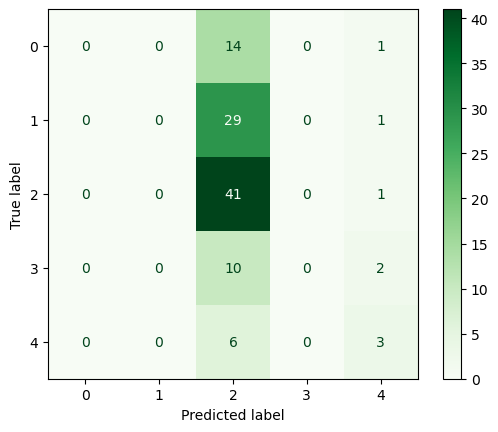

In [58]:
cm_ada = confusion_matrix(y_true=y_ada_test, y_pred=y_ada_pred)
ConfusionMatrixDisplay(cm_ada).plot(cmap=plt.cm.Greens)

In [60]:
roc_auc_ada = roc_auc_score(y_ada_test.values.ravel(),optimal_ada_model.predict_proba(X_ada_test),multi_class='ovo')
print(f"ROC AUC Score for AdaBoost Model: {roc_auc_ada} ")

ROC AUC Score for AdaBoost Model: 0.549936507936508 


# Random Forest

In [61]:
X_rf = data[["image_width", "image_height"]]
y_rf = data['label']
# Split the dataset into training and test datasets
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y_rf, test_size = 0.2, random_state = 42)

In [63]:
rf_pipe = Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier())])
#Hyperparameter tuning
hyperparameters = {'classifier__n_estimators' : [10, 25, 50], 
                   'classifier__criterion': ['entropy', 'gini'], 
                   'classifier__max_depth' : [10, 20, 50]
                 }

grid_search = GridSearchCV(rf_pipe, hyperparameters, cv=5, scoring='accuracy')
grid_search.fit(X_rf_train, y_rf_train.values.ravel())
print(f"Best Parameters : {grid_search.best_params_}")
print(f"Best AccuracyScore : {grid_search.best_score_}")

Best Parameters : {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__n_estimators': 25}
Best AccuracyScore : 0.36046511627906974


In [64]:
optimal_rf_model = grid_search.best_estimator_
y_rf_pred = optimal_rf_model.predict(X_rf_test)

In [65]:
print(classification_report(y_rf_test, y_rf_pred))

              precision    recall  f1-score   support

          CC       0.15      0.13      0.14        15
          EC       0.38      0.20      0.26        30
        HGSC       0.39      0.67      0.50        42
        LGSC       1.00      0.08      0.15        12
          MC       0.14      0.11      0.12         9

    accuracy                           0.35       108
   macro avg       0.41      0.24      0.24       108
weighted avg       0.40      0.35      0.31       108



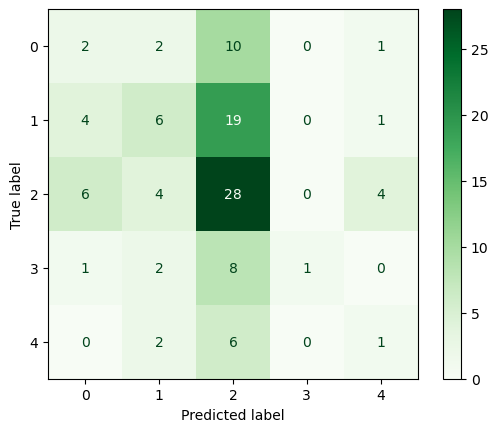

In [67]:
cm_rf = confusion_matrix(y_true=y_rf_test, y_pred=y_rf_pred)
ConfusionMatrixDisplay(cm_rf).plot(cmap=plt.cm.Greens)

In [68]:
roc_auc_rf = roc_auc_score(y_rf_test.values.ravel(),optimal_rf_model.predict_proba(X_rf_test),multi_class='ovo')
print(f"ROC AUC Score for Random Forest Model: {roc_auc_rf} ")

ROC AUC Score for Random Forest Model: 0.5321607142857143 
